First, let's do some set up.

In [3]:
import pandas as pd

from scipy.stats import chi2_contingency, ttest_ind
from scipy.stats.contingency import relative_risk, odds_ratio

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sns.set_theme(style="ticks", palette="pastel")

In [5]:
pd.read_csv?

Time to read in data.

In [8]:
df_study = pd.read_csv("../resources/clinical-study.csv")
df_protein = pd.read_csv("../resources/protein-levels.csv")

Join the two tables.

In [9]:
df = pd.merge(df_study, df_protein, "left", left_on = "subject_id", right_on = "participant_id")

And inspect the resulting data frame briefly.

In [10]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772 entries, 0 to 771
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subject_id             772 non-null    object 
 1   age                    772 non-null    float64
 2   sex                    772 non-null    object 
 3   weight                 761 non-null    float64
 4   height                 772 non-null    float64
 5   trt_grp                772 non-null    object 
 6   RESPONSE               772 non-null    object 
 7   participant_id         769 non-null    object 
 8   protein_concentration  764 non-null    float64
dtypes: float64(4), object(5)
memory usage: 60.3+ KB


Now, add a BMI column.

In [11]:
df["bmi"] = round(df["weight"] / (df["height"] ** 2), 1)

Do some clean-up by renaming columns and moving _bmi_ after _weight_

In [12]:
df.columns

Index(['subject_id', 'age', 'sex', 'weight', 'height', 'trt_grp', 'RESPONSE',
       'participant_id', 'protein_concentration', 'bmi'],
      dtype='object')

In [13]:
df = df[['subject_id', 'age', 'sex', 'weight', 'bmi', 'height', 'trt_grp',
       'RESPONSE', 'protein_concentration']]

df = df.rename(columns = {"trt_grp": "treatment_group",
                    "RESPONSE": "response",
                         "subject_id": "participant_id"})

Now let's remove pediatric patients and duplicates

In [14]:
df = df[df.age >= 21]
df[df.age < 21]

,participant_id,age,sex,weight,bmi,height,treatment_group,response,protein_concentration


In [15]:
df.drop_duplicates(inplace = True)

Let's check if there are any missing values.

In [16]:
df.isna().any()

participant_id           False
age                      False
sex                      False
weight                    True
bmi                       True
height                   False
treatment_group          False
response                 False
protein_concentration     True
dtype: bool

So there are missing values in weight, BMI and protein concentration.

Counts of missing values follow.

In [17]:
len(df) - df.count()

participant_id            0
age                       0
sex                       0
weight                   11
bmi                      11
height                    0
treatment_group           0
response                  0
protein_concentration     5
dtype: int64

There are 11 missing values in weight (and hence BMI) and 5 missing values in protein concentration. Compared to 768 observations, that is not many. We will just let pandas ignore them.

Now, let's inspect if the data is valid.

In [18]:
df.sex.unique()
df.sex.value_counts()

Female    389
Male      379
Name: sex, dtype: int64

In [19]:
df.treatment_group.value_counts()

CONTROL    385
DRUG       383
Name: treatment_group, dtype: int64

In [20]:
df.weight.min()

46.17

The data is now clean and ready for analysis. Let's look at its final form.

In [21]:
df.head()

,participant_id,age,sex,weight,bmi,height,treatment_group,response,protein_concentration
0,SUBJ_001,46.0,Female,84.66,33.5,1.59,DRUG,N,148.0
2,SUBJ_002,47.0,Female,71.21,26.5,1.64,DRUG,Y,85.0
3,SUBJ_003,48.0,Female,69.85,23.3,1.73,CONTROL,N,183.0
4,SUBJ_004,59.0,Female,62.94,28.0,1.50,DRUG,Y,89.0
5,SUBJ_005,59.0,Female,113.91,42.9,1.63,CONTROL,N,137.0


-----------------------------------------------------------------

Let's check if treatment groups are balanced.

In [22]:
df[df.treatment_group == "DRUG"].participant_id.count()

383

In [23]:
df[df.treatment_group == "CONTROL"].participant_id.count()

385

In [24]:
df[df.treatment_group == "DRUG"].sex.value_counts()

Male      196
Female    187
Name: sex, dtype: int64

In [25]:
df[df.treatment_group == "CONTROL"].sex.value_counts()

Female    202
Male      183
Name: sex, dtype: int64

In [26]:
df[df.treatment_group == "DRUG"].age.mean()

61.759791122715406

In [27]:
df[df.treatment_group == "CONTROL"].age.mean()

61.862337662337666

In [28]:
df[df.treatment_group == "DRUG"].bmi.mean()

31.986807387862797

In [29]:
df[df.treatment_group == "CONTROL"].bmi.mean()

32.66719576719577

In [30]:
df[df.treatment_group == "DRUG"].height.mean()

1.6827415143603133

In [31]:
df[df.treatment_group == "CONTROL"].height.mean()

1.6758181818181819

In [32]:
df[df.treatment_group == "DRUG"].protein_concentration.mean()

122.08179419525067

In [33]:
df[df.treatment_group == "CONTROL"].protein_concentration.mean()

121.296875

Or we can do the same but better by using `groupby`

In [34]:
df.groupby("treatment_group").sex.value_counts()

treatment_group  sex   
CONTROL          Female    202
                 Male      183
DRUG             Male      196
                 Female    187
Name: sex, dtype: int64

In [35]:
df.groupby("treatment_group").mean(numeric_only = True).round(2)

,age,weight,bmi,height,protein_concentration
treatment_group,,,,,
CONTROL,61.86,91.94,32.67,1.68,121.30
DRUG,61.76,90.84,31.99,1.68,122.08


The treatment groups look to be well balanced.

---------------------------------------------------

Now let's look at the responses to answer the question: is the drug effective?

In [36]:
contingency = pd.crosstab(index = df['treatment_group'], columns =
                          df['response']).reindex(index =["DRUG", "CONTROL"], columns= ["Y", "N"])
contingency

response,Y,N
treatment_group,,
DRUG,210,173
CONTROL,124,261


In [37]:
print(f"In the drug group, a proportion of {round(210/(173+210),3)} participants had a response.")
print(f"In the control group, a proportion of {round(124/(124+261),3)} participants had a response.")

In the drug group, a proportion of 0.548 participants had a response.
In the control group, a proportion of 0.322 participants had a response.


In [38]:
chi2_contingency(contingency).pvalue

4.0953175442471774e-10

The _p-value_ in the chi-squared test for no association is very small, therefore there is very strong evidence against the null hypothesis. There is very strong evidence of a positive association between taking the drug and having a response. The drug is effective. But how effective?

In [39]:
result = relative_risk(210, 210+173, 124, 123 + 261)
round(result.relative_risk, 2)

1.7

In [40]:
result.confidence_interval(0.95)

ConfidenceInterval(low=1.4310965729442944, high=2.0146108947467827)

In [41]:
result_odds = odds_ratio(contingency, kind="sample")
round(result_odds.statistic, 1)

2.6

In [42]:
result_odds.confidence_interval(0.95)

ConfidenceInterval(low=1.9049662776388707, high=3.4268629453145794)

RR = 1.7 with 95% CI (1.4, 2.0); OR = 2.6 with 95% CI (1.9, 3.4).

Therefore, the patients saw a substantial benefit.

-----------------------------------------------------------------

The question to answer now is which subgroups of patients are benefiting more from the treatment?

In [43]:
grouped_by_r = df.groupby("response")
grouped_by_r[["age", "weight", "bmi", "height", "protein_concentration"]].mean().round(2)

,age,weight,bmi,height,protein_concentration
response,,,,,
N,61.75,89.92,31.86,1.68,134.98
Y,61.89,93.26,32.93,1.68,104.43


In [44]:
grouped_by_t_r = df.groupby(["treatment_group", "response"])
grouped_by_t_r[["age", "weight", "bmi", "height", "protein_concentration"]].mean().round(2)

age  weight    bmi  height  protein_concentration
treatment_group response                                                     
CONTROL         N         62.04   89.76  31.88    1.68                 128.80
                Y         61.48   96.40  34.28    1.67                 105.38
DRUG            N         61.31   90.16  31.83    1.68                 144.46
                Y         62.13   91.39  32.12    1.69                 103.88

In [45]:
grouped_by_r.groups
grouped_by_t_r.groups
df_test = grouped_by_t_r.get_group(('CONTROL', 'N'))

Mean ages across groups look similar. Let's produce a boxplot of ages.

<Axes: xlabel='treatment_group', ylabel='age'>

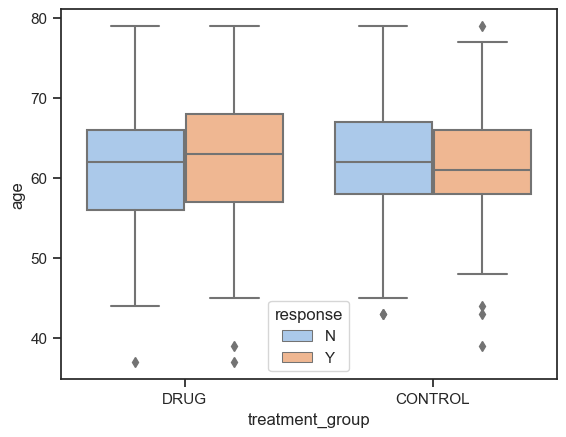

In [46]:
sns.boxplot(x = "treatment_group", y = "age", hue = "response", data = df)

Distributions of ages are similar across groups.

Mean BMI is slightly higher for responders. Let's investigate with a boxplot.

<Axes: xlabel='treatment_group', ylabel='bmi'>

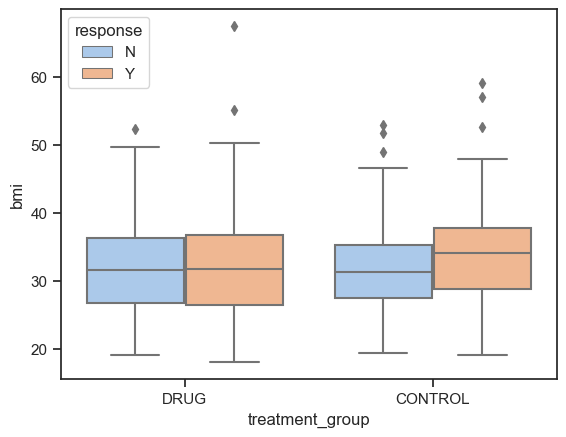

In [47]:
sns.boxplot(x = "treatment_group", y = "bmi", data = df, hue = "response")

Distrubution of BMI is similar across groups, except there are more extreme high values among responders. In the drug group, the distributions are nearly identical.

We can perform a t-test for the difference between means too

In [48]:
ttest_ind(grouped_by_t_r.get_group(('DRUG', 'Y')).bmi.to_list(), grouped_by_t_r.get_group(('DRUG', 'N')).bmi.to_list(),
         nan_policy = 'omit')

Ttest_indResult(statistic=0.3961791857001643, pvalue=0.6921969755786451)

In [49]:
ttest_ind(grouped_by_r.get_group('Y').bmi, grouped_by_r.get_group('N').bmi,
         nan_policy = 'omit')

Ttest_indResult(statistic=2.1139269000207617, pvalue=0.03484884491794387)

There is no difference in the distributions of BMIs for responders and non-responders in the drug group. There is moderate evidence of a difference in mean BMI between all responders and all non-reponders, but considering there are more high potential outliers among responders, this doesn't not appear to be important.

The mean protein concentration is lower for responders (mean 104) than for non-responder (mean 135). Let's produce a boxplot.

<Axes: xlabel='response', ylabel='protein_concentration'>

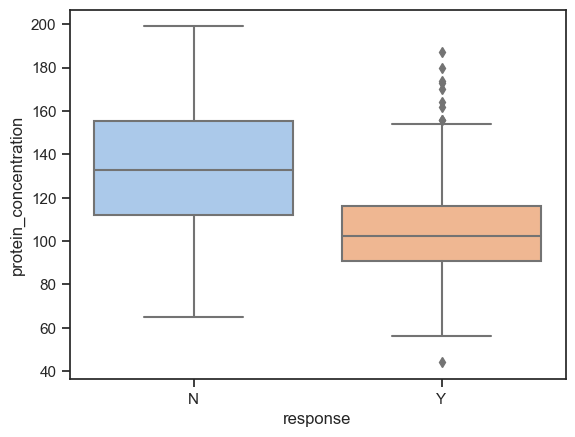

In [50]:
sns.boxplot(x = "response", y = "protein_concentration", data = df)

And a histogram of the distributions of protein concentration among the different groups.

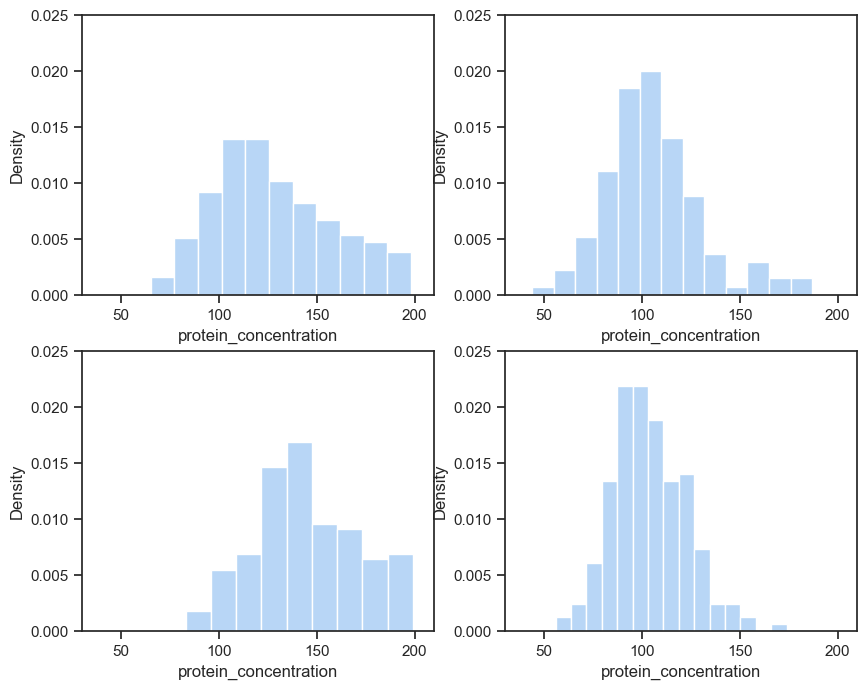

In [51]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))
plt.setp(ax, xlim = (30, 210), ylim=(0,  0.025))

sns.histplot(x = "protein_concentration", data = grouped_by_t_r.get_group(('DRUG', 'N')), stat = "density", ax = ax[1, 0])
sns.histplot(x = "protein_concentration", data = grouped_by_t_r.get_group(('DRUG', 'Y')), stat = "density", ax = ax[1, 1])

sns.histplot(x = "protein_concentration", data = grouped_by_t_r.get_group(('CONTROL', 'N')), stat = "density", ax = ax[0, 0])
sns.histplot(x = "protein_concentration", data = grouped_by_t_r.get_group(('CONTROL', 'Y')), stat = "density", ax = ax[0, 1])

plt.show()

Or, better.

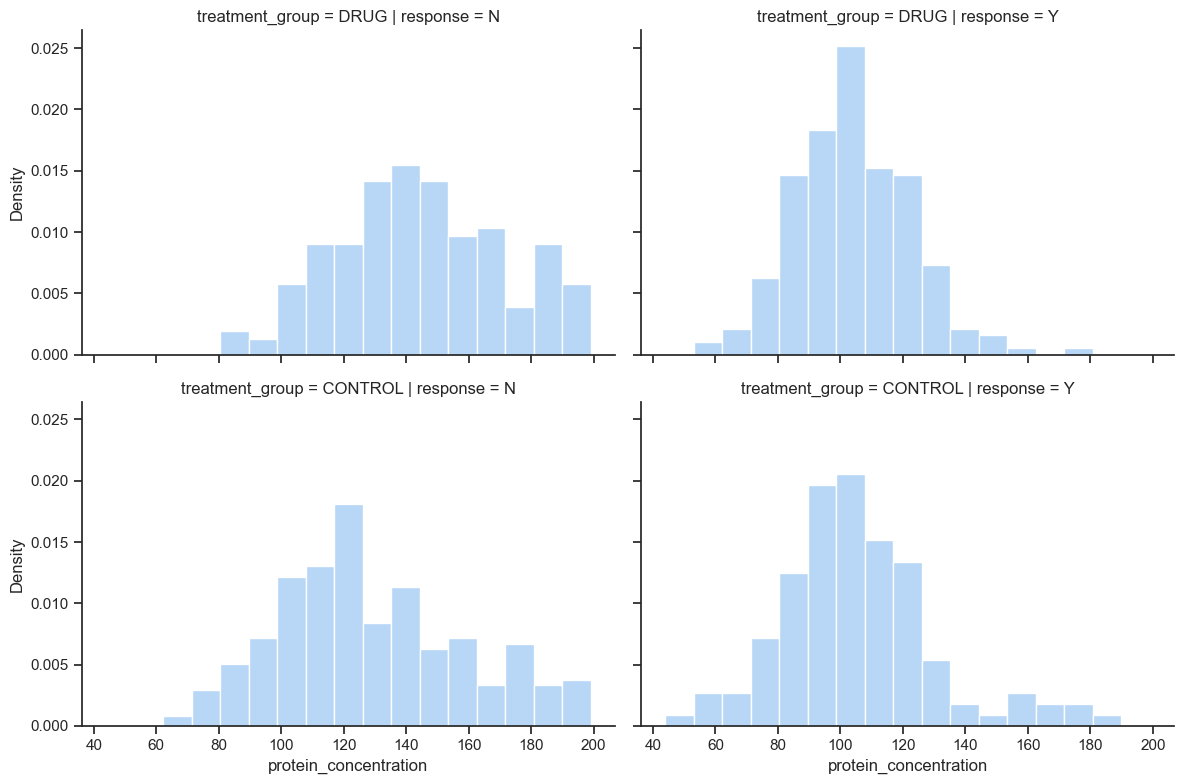

In [52]:
sns.displot(df, x = "protein_concentration", row = "treatment_group", col = "response", stat = "density",
            height = 4, aspect = 1.5, common_norm = False)

Responders tend to have a protein concentration below 140. For non-reponders, the high end of possible range of values is much higher.

We can perform a two-sample t-test.

In [53]:
ttest_ind(grouped_by_r.get_group('Y').protein_concentration, grouped_by_r.get_group('N').protein_concentration,
         nan_policy = 'omit')

Ttest_indResult(statistic=-15.766937692608886, pvalue=1.1280938358273306e-48)

There is very strong evidence that the mean protein concentration is lower for responders compared to non-responders.